In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

import warnings
warnings.simplefilter("ignore")

In [2]:
entropy = pd.read_csv("entropy.csv")
accuracy = pd.read_csv("RFCs_accuracy.csv")
cm = pd.read_csv("classification_metric.csv")
dm = pd.read_csv("diameter_metric.csv").drop("Unnamed: 0", axis=1)

entropy["cond_entropy"] = entropy["cond_entropy"]/max(entropy["cond_entropy"])
cm["cm"] = cm["cm"]/max(cm["cm"])

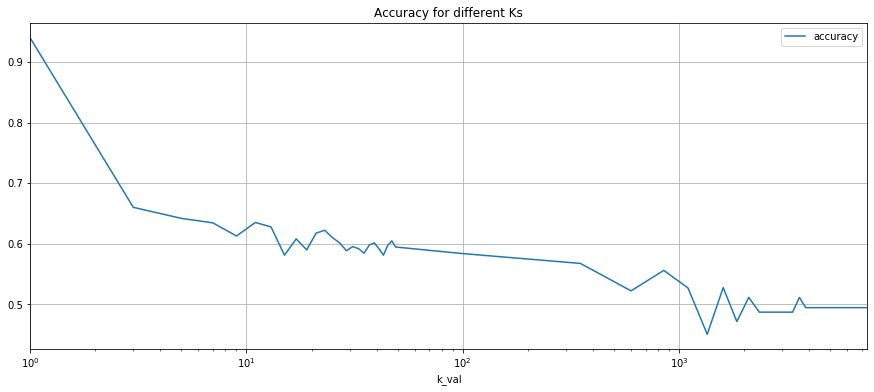

In [3]:
accuracy.plot("k_val", "accuracy", figsize=(15,6), grid=True, logx=True, title="Accuracy for different Ks")

In [4]:
data = pd.DataFrame()
data[["k_val","accuracy"]] = accuracy[["k_val", "accuracy"]]
data = data.merge(entropy)
data = data.merge(cm)
data = data.merge(dm)

In [5]:
data.head()

,k_val,accuracy,cond_entropy,cm,dm
0,1,0.939865,0.000000,0.000000,1.00
1,3,0.660135,0.952428,0.495087,0.55
2,5,0.641892,0.956839,0.581605,0.50
3,7,0.634459,0.956854,0.581332,0.50
4,9,0.612838,0.961178,0.647107,0.45


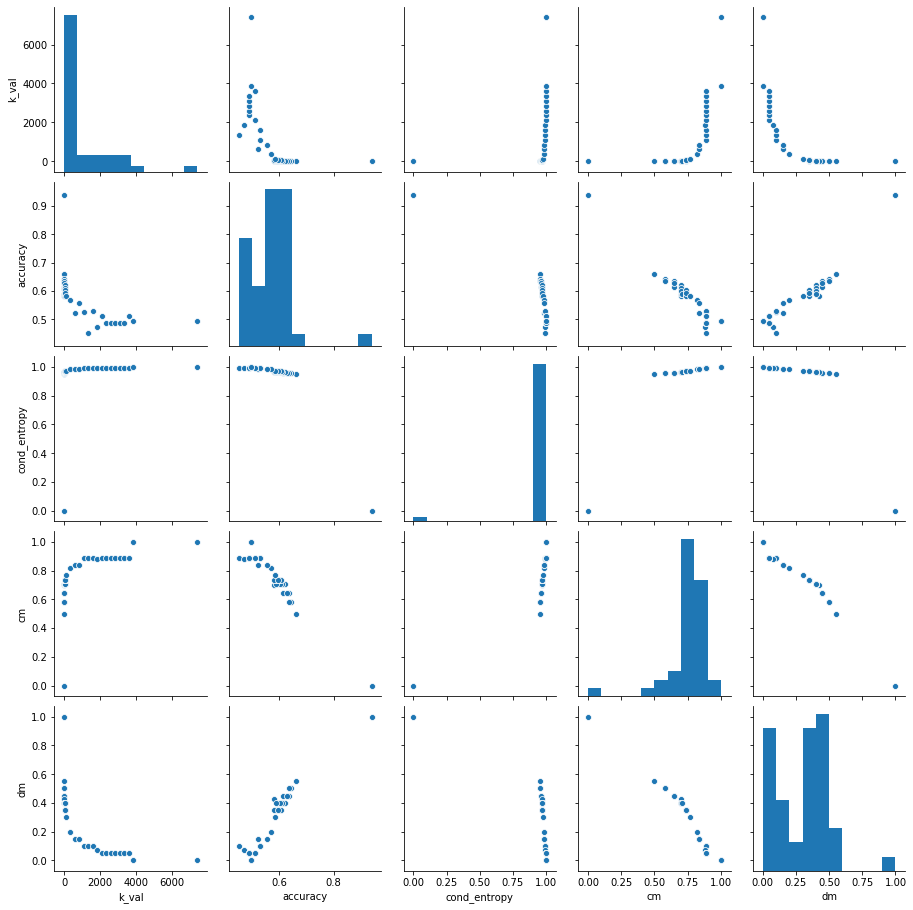

In [6]:
sbn.pairplot(data)

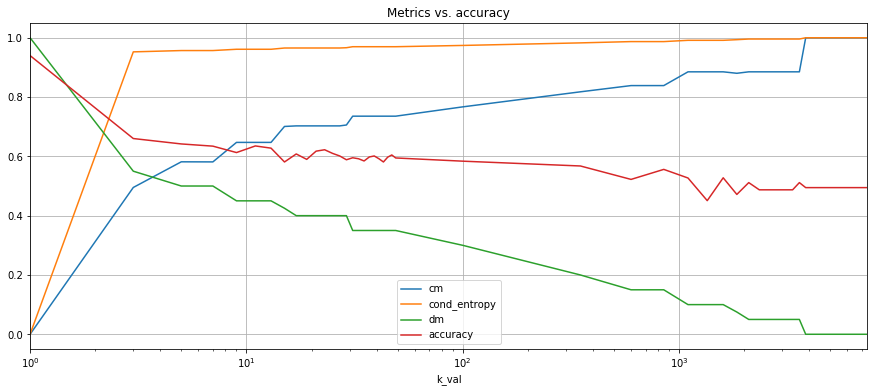

In [7]:
data.plot("k_val", ["cm", "cond_entropy", "dm", "accuracy"], figsize=(15,6), grid=True, logx=True, title="Metrics vs. accuracy")

# Linear Regression



In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressors):
    X = data[regressors]
    y = data["accuracy"]

    reg = LinearRegression()
    reg.fit(X, y)
    print(f"R2 Score: {reg.score(X,y)}")
    print(f"Coeffs: {reg.coef_}")
    print(f"Intercept: {reg.intercept_}")
    return reg, reg.coef_, reg.intercept_

def mse(reg, attributes):
    attrs = np.array(data[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = data["accuracy"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

### Conditional Entropy

R2 Score: 0.6098098923651292
Coeffs: [-0.41188189]
Intercept: 0.9680539344499206
MSE: 0.0024278994045114914


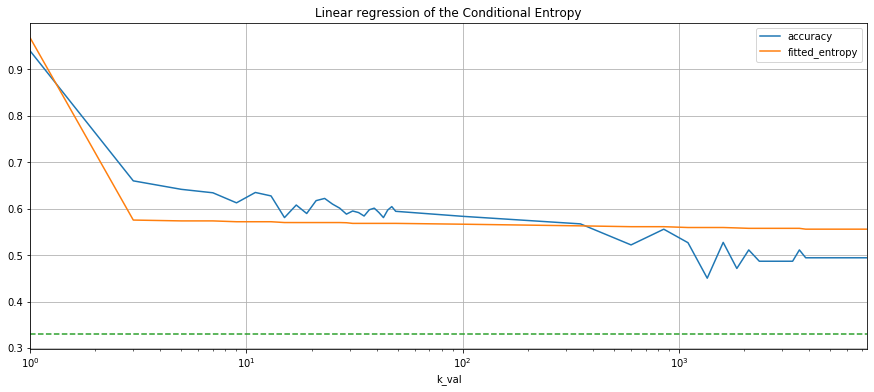

In [9]:
reg, coeff, intercept = regress(["cond_entropy"])
entropy_reg = data[["k_val", "accuracy", "cond_entropy"]]
entropy_reg["fitted_entropy"] = coeff*entropy_reg["cond_entropy"] + intercept
entropy_reg.plot("k_val", ["accuracy", "fitted_entropy"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of the Conditional Entropy")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cond_entropy'])
mses.append((True, False, False, coeff[0], None, None, err))
print(f"MSE: {err}")


### Classification Metric

R2 Score: 0.9272270983827473
Coeffs: [-0.47349582]
Intercept: 0.9313110362141946
MSE: 0.00045281846219032883


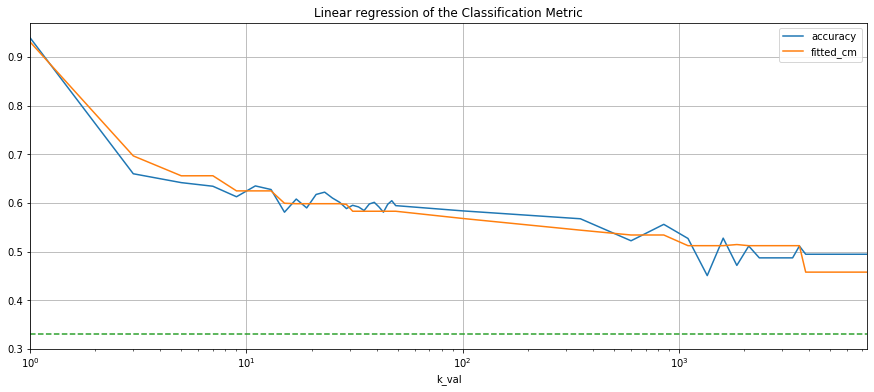

In [10]:
reg, coeff, intercept = regress(["cm"])
cm_reg = data[["k_val", "accuracy", "cm"]]
cm_reg["fitted_cm"] = coeff*cm_reg["cm"] + intercept
cm_reg.plot("k_val", ["accuracy", "fitted_cm"], figsize=(15,6), grid=True,
            logx=True, title="Linear regression of the Classification Metric")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cm'])
mses.append((False,True,False,None,coeff[0], None, err))
print(f"MSE: {err}")

### Diameter Metric

R2 Score: 0.9058002984532965
Coeffs: [0.37889351]
Intercept: 0.46577761972498816
MSE: 0.0005861435100871904


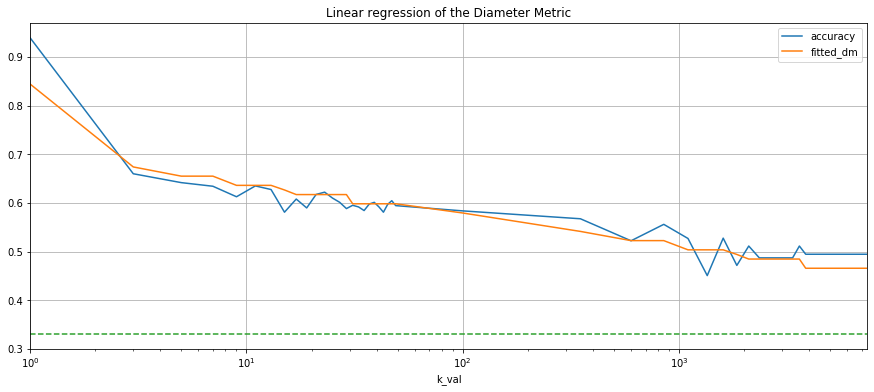

In [11]:
reg, coeff, intercept = regress(["dm"])
cm_reg = data[["k_val", "accuracy", "dm"]]
cm_reg["fitted_dm"] = coeff*cm_reg["dm"] + intercept
cm_reg.plot("k_val", ["accuracy", "fitted_dm"], figsize=(15,6), grid=True,
            logx=True, title="Linear regression of the Diameter Metric")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['dm'])
mses.append((False, False,True,None, None, coeff[0], err))
print(f"MSE: {err}")

### Entropy & CM

**Entropy more relevant this time...**

R2 Score: 0.9282201832332836
Coeffs: [-0.02716415 -0.45346543]
Intercept: 0.942151230842108
MSE: 0.00044663914070044964


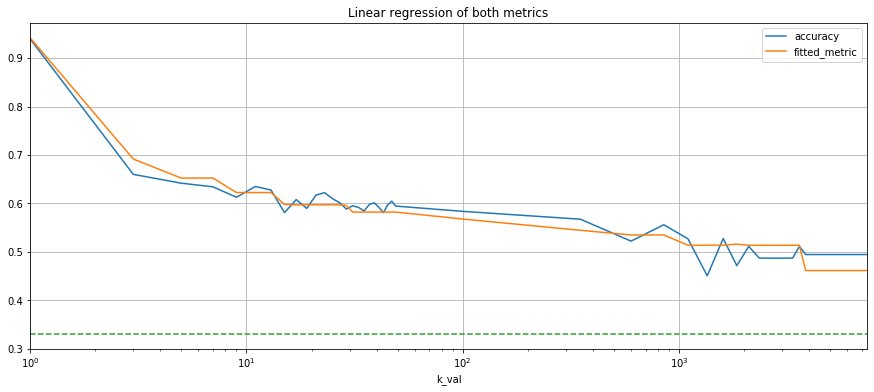

In [12]:
reg, coeffs, intercept = regress(["cond_entropy", "cm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "cm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["cm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of both metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")


err = mse(reg, ['cond_entropy','cm'])
mses.append((True, True, False, coeffs[0], coeffs[1], None, err))
print(f"MSE: {err}")

### Entropy & DM

R2 Score: 0.9576693073727035
Coeffs: [-0.1556308   0.30420681]
Intercept: 0.6357541275728822
MSE: 0.0002633963839968632


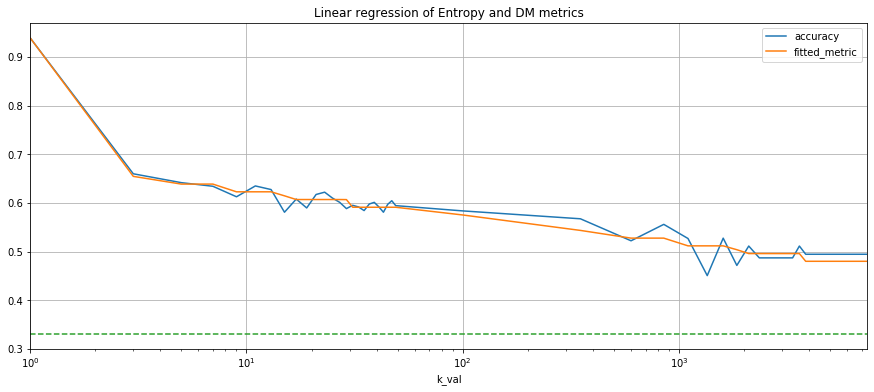

In [13]:
reg, coeffs, intercept = regress(["cond_entropy", "dm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "dm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["dm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of Entropy and DM metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cond_entropy','dm'])
mses.append((True, False, True, coeffs[0], None, coeffs[1], err))
print(f"MSE: {err}")

### CM & DM

R2 Score: 0.9379544206273549
Coeffs: [ 0.14258436 -0.30490651]
Intercept: 0.7633354999118116
MSE: 0.00038606930894409194


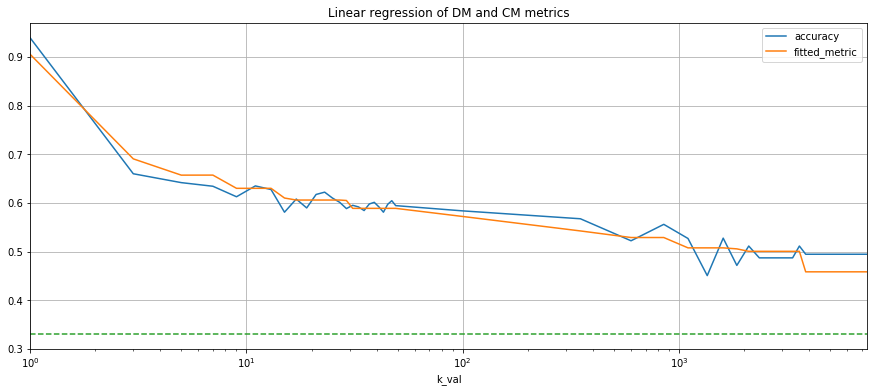

In [14]:
reg, coeffs, intercept = regress(["dm", "cm"])
m_reg = data[["k_val", "accuracy", "dm", "cm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["dm"] + coeffs[1]*m_reg["cm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of DM and CM metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['dm','cm'])
mses.append((False, True, True, None, coeffs[0], coeffs[1], err))
print(f"MSE: {err}")

### All 3 Metrics

R2 Score: 0.9578041341618051
Coeffs: [-0.16686302  0.03421983  0.32533762]
Intercept: 0.6146266209534208
MSE: 0.00026255744452975097


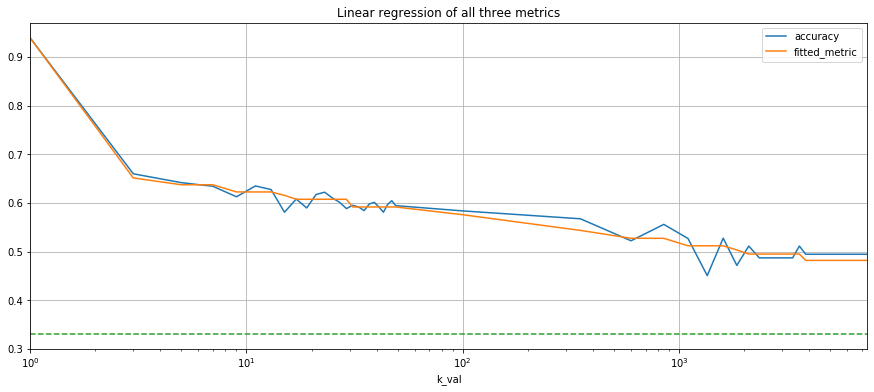

In [15]:
reg, coeffs, intercept = regress(["cond_entropy", "cm", "dm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "cm", "dm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["cm"] + coeffs[2]*m_reg["dm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of all three metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")


err = mse(reg, ['cond_entropy','cm','dm'])
mses.append((True, True, True, coeffs[0], coeffs[1], coeffs[2], err))
print(f"MSE: {err}")

In [16]:
def display_mses(mses):
    s = [[str(e) for e in row] for row in mses]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print("\n".join(table))
    
df = pd.DataFrame(mses, columns=["Entropy", "CM", "DM", "Entropy_coeff", "CM_coeff", "DM_coeff", "MSE"])
#display_mses(mses)

In [17]:
df

,Entropy,CM,DM,Entropy_coeff,CM_coeff,DM_coeff,MSE
0,True,False,False,-0.411882,NaN,NaN,0.002428
1,False,True,False,NaN,-0.473496,NaN,0.000453
2,False,False,True,NaN,NaN,0.378894,0.000586
3,True,True,False,-0.027164,-0.453465,NaN,0.000447
4,True,False,True,-0.155631,NaN,0.304207,0.000263
5,False,True,True,NaN,0.142584,-0.304907,0.000386
6,True,True,True,-0.166863,0.034220,0.325338,0.000263
